In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

import importlib

## Synthetic Example

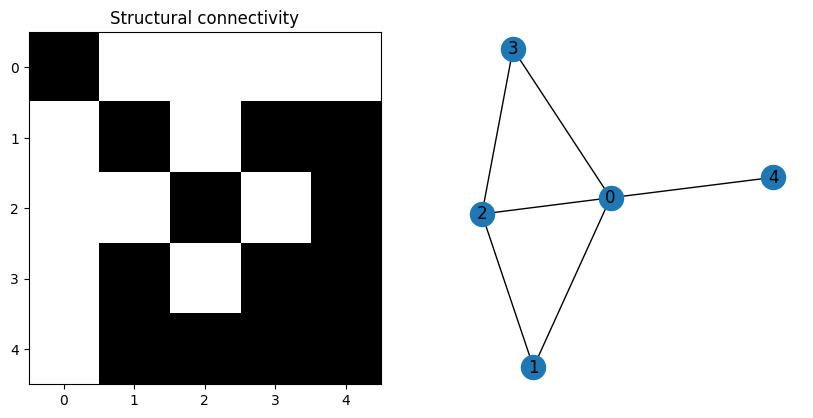

In [2]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_synthetic.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### Example of a forward pass

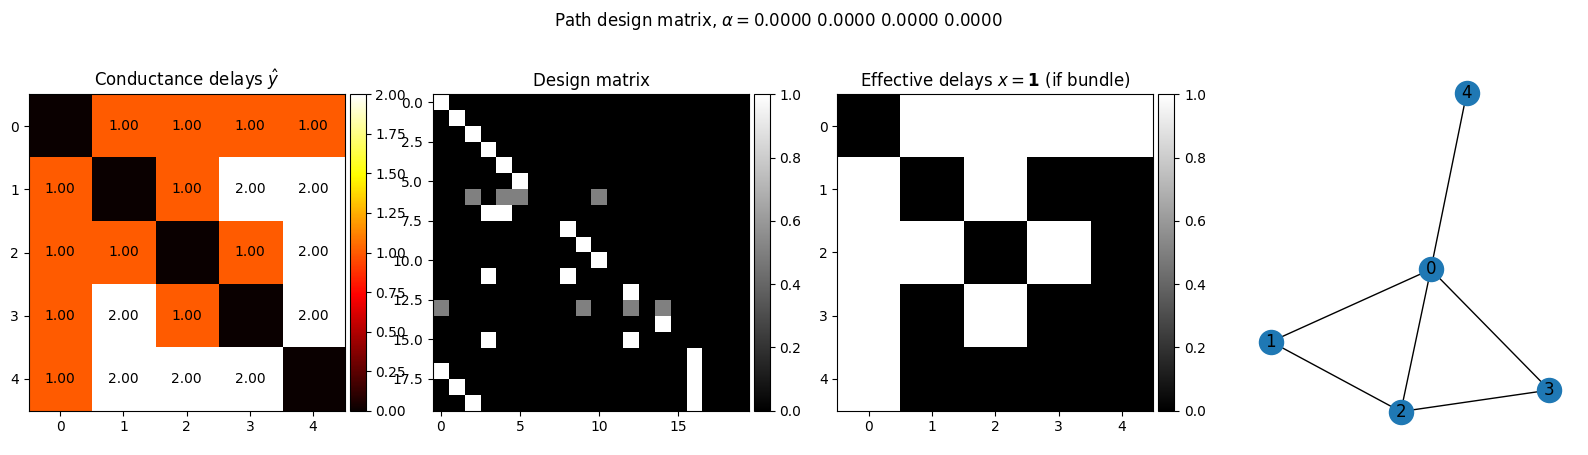

In [4]:
max_path_depth = 4

# multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

# design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Backward pass: Initialization with pseudo-inverse + iterative optimization

In [5]:
max_path_depth = 4

a = 0
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

x_ground = utils.remove_diagonal_entries(adj).flatten()

alpha = solver.torch.tensor(alpha)

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())

y_ground = solver.torch.tensor(utils.deepcopy(y_pred))
init_pseudo = False
if init_pseudo:
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

# alphas_init = solver.torch.tensor(np.random.rand(len(alpha))).requires_grad_(True)

/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_99267/1241894738.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [11]:
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=1000, verbose=False, early_stop=1e-10, step_size=1e-2)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.025'}>)

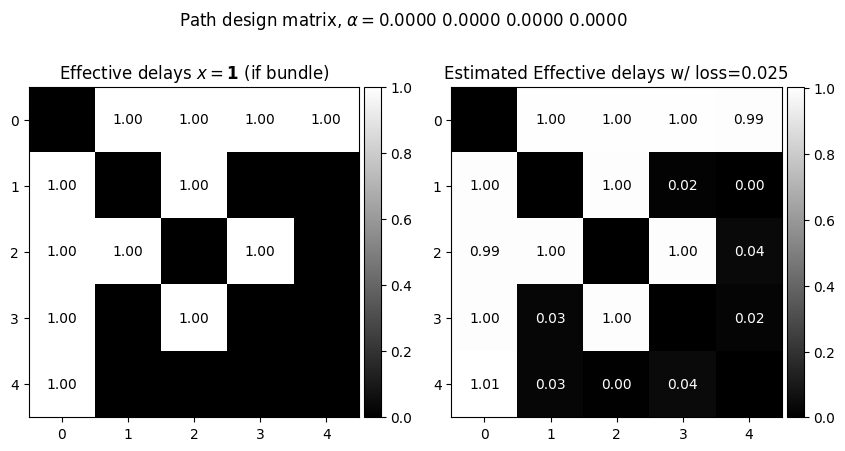

In [12]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# NOTE: we need to rechek this, it seems that the colors are flipped? (transposed?)
utils.annotate_heatmap(fig, axes[1], x_pred_mat.T, adapt_color=0.6)

## F-tract Example

Contents:
- Sanity check 
    - generating measured delay by considering only 1s delay for all bundles
    - verifying that the solver regresses back the only 1 delays

- Regressing conductance delays

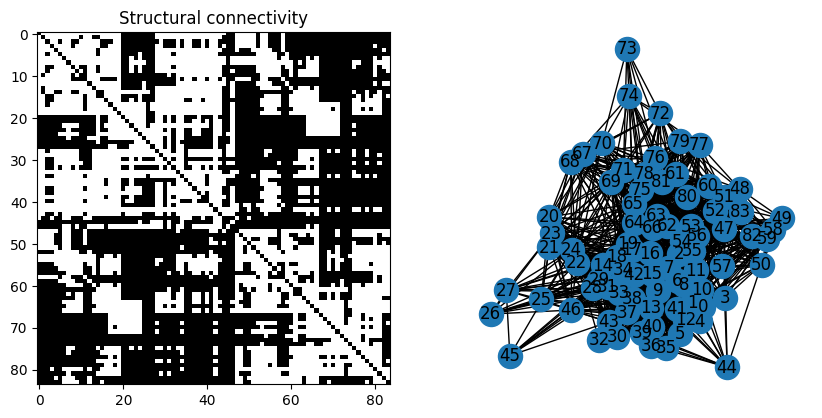

In [2]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))
# TODO + NOTE: temporary truncation to remove (by michael)
adj = adj[:84, :84] 
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

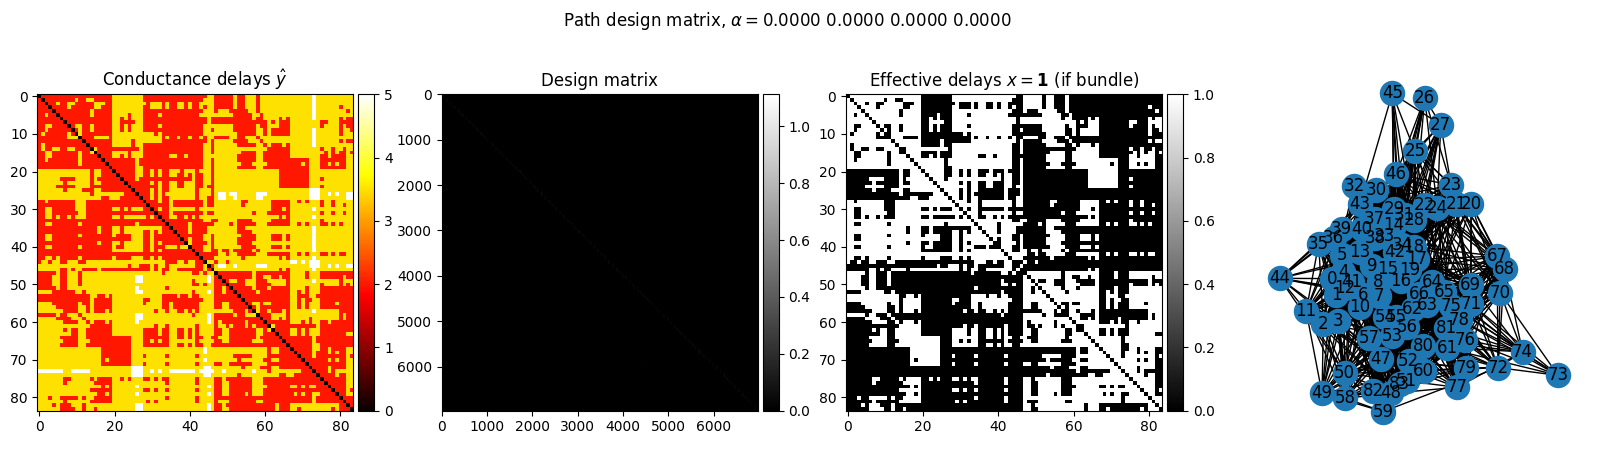

In [15]:
max_path_depth = 3

#multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

#a = 0
# Computes the alpha vector as alpha_n = a^n
#alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

#design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=0.5)

y_pred_mat = regmod.predict_conduction_delays(design_shortest, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot', interpolation=None)
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
#utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_shortest, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Sanity check

In [20]:
n_reduced = -1
reduced_adj = adj[:n_reduced][:, :n_reduced]

x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()

a = 0.5
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

#design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)

design_shortest = regmod.build_design_shortest(reduced_adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)
x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [21]:
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
y_ground = solver.torch.tensor(utils.deepcopy(y_pred))

init_pseudo = False
if init_pseudo:
    x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_99267/2588998287.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [33]:
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=5000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-2)

  0%|          | 0/5000 [00:00<?, ?it/s]

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.7397'}>)

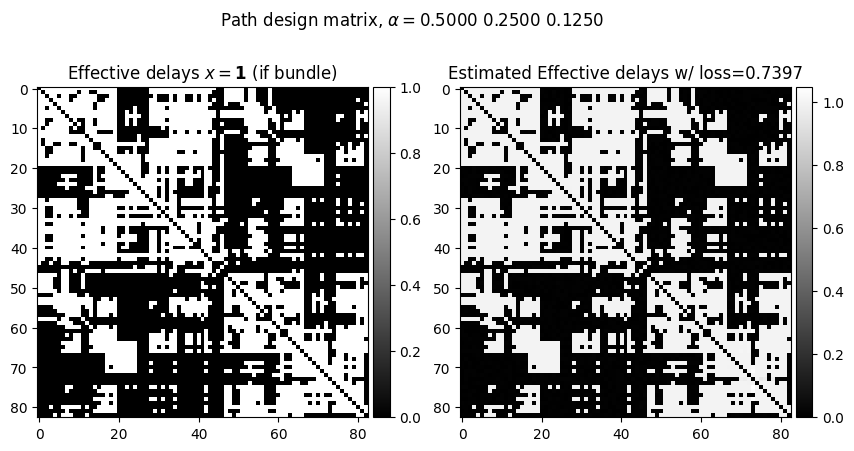

In [34]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

Text(0.5, 0, 'Delay differences')

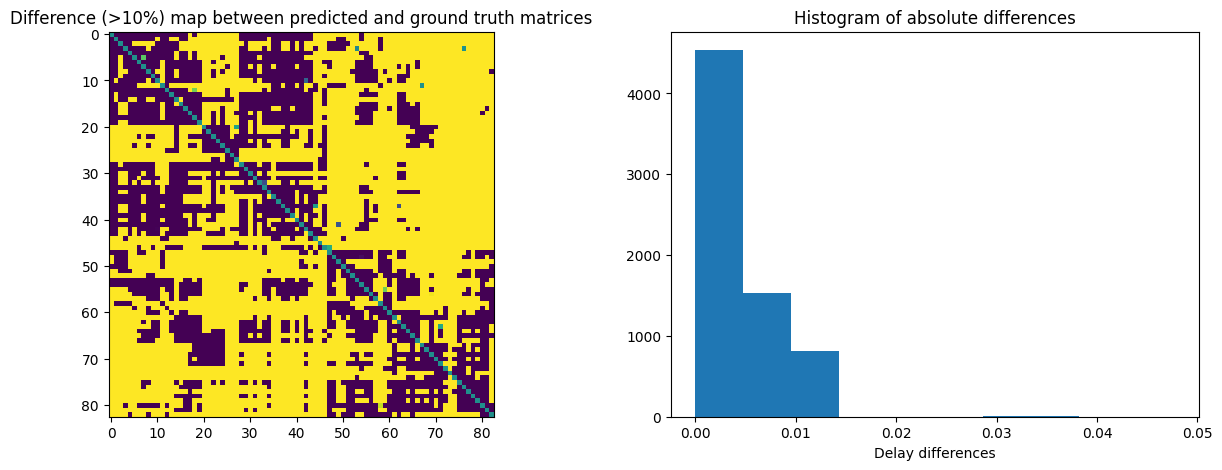

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
ax[0].imshow(x_pred_mat - x_ground_mat, vmin=-1e-5, vmax=1e-5)
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(x_pred_mat - x_ground_mat).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

### From conductance delay

In [11]:
n_reduced = -1

y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])[:n_reduced][:, :n_reduced]

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [12]:
max_path_depth = 3

adj_reduced = adj[:n_reduced][:, :n_reduced]

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]

#design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha).numpy()
design_shortest = regmod.build_design_shortest(adj_reduced, n_subopt=0, alpha=a)
design_model = solver.torch.tensor(design_shortest)

In [7]:
init_pseudo = False
if init_pseudo:
    x_pseudo = solver.pseudo_inverse(y_ground, a_design=design_model.numpy(), rcond=1e-10)
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

In [25]:
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=20000, verbose=True, 
                                            early_stop=1e-10, step_size=5e-1)

  0%|          | 0/20000 [00:00<?, ?it/s]

###### ITER 0 #######
datafit loss: 1586.0126379932444
L2 norm: 47.83429872488418
positivity loss: 0.0

###### ITER 2000 #######
datafit loss: 1405.4783071236718
L2 norm: 170.5790073754764
positivity loss: 0.00356479231384563

###### ITER 4000 #######
datafit loss: 1373.76801826558
L2 norm: 201.23552926818488
positivity loss: 0.003458327379859425

###### ITER 6000 #######
datafit loss: 1365.9191670019652
L2 norm: 209.0384268958699
positivity loss: 0.00432961970695829

###### ITER 8000 #######
datafit loss: 1363.8453042060603
L2 norm: 211.06263055735442
positivity loss: 0.01235877486484248

###### ITER 10000 #######
datafit loss: 1363.3485476875708
L2 norm: 211.61375657504797
positivity loss: 0.0001512233225369059

###### ITER 12000 #######
datafit loss: 1363.1932089639033
L2 norm: 211.75087849393051
positivity loss: 0.0053099501017888455

###### ITER 14000 #######
datafit loss: 1363.1449586981362
L2 norm: 211.79209055107466
positivity loss: 0.015566565206255187

###### ITER 16000 #####

(<Figure size 1500x500 with 6 Axes>,
 <Axes: title={'center': 'Clipped $\\hat y$'}>)

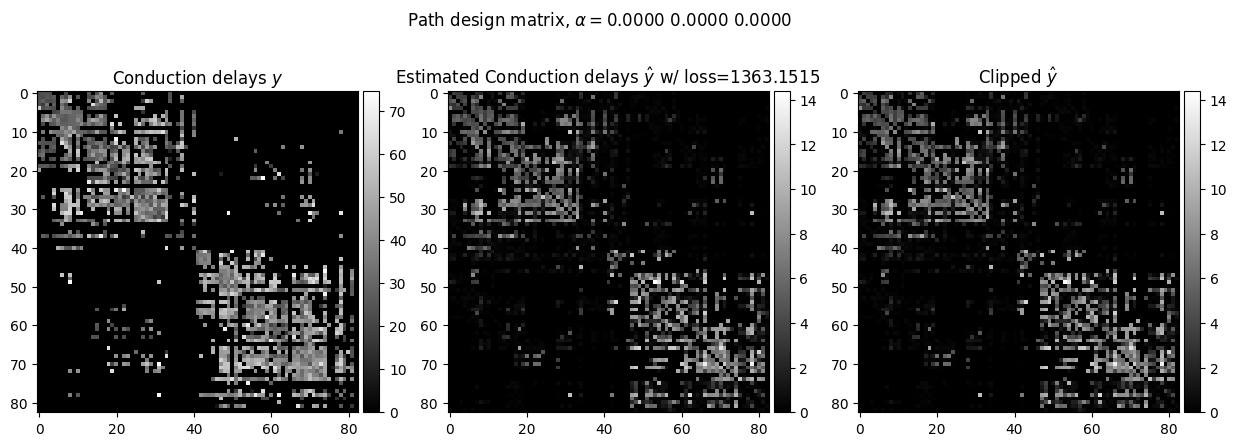

In [26]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes, np.round(x_pred_mat,4), adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated Conduction delays $\hat y$ w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])

axes[2].imshow(x_pred_mat, cmap='gray', vmin=0)
axes[2].set_title(f"Clipped $\hat y$")
utils.add_cbar(fig, axes[2])

Text(0.5, 0, 'Delay differences')

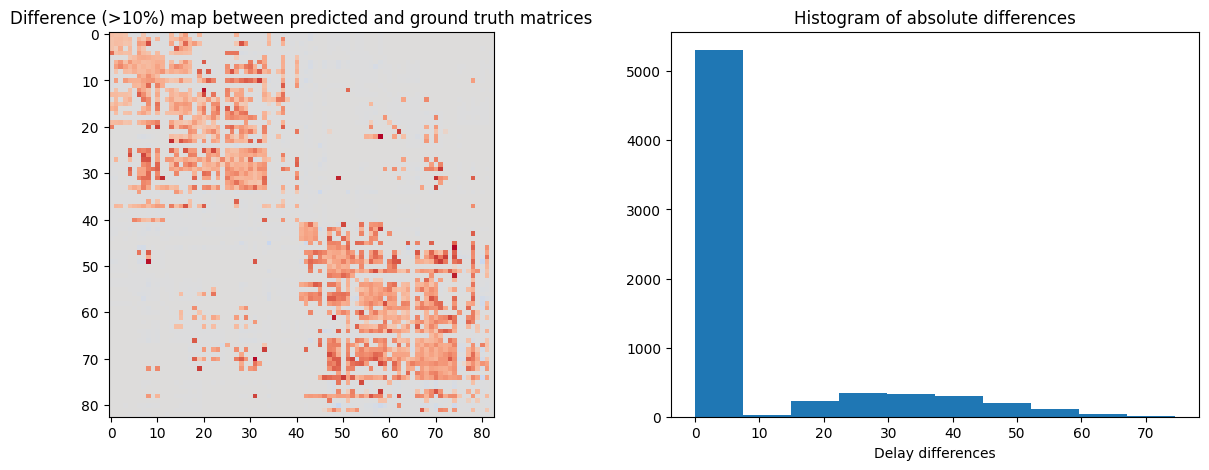

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
diff = y_ground_mat - x_pred_mat
maxval = np.abs(diff).max()

ax[0].imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(diff).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

# Visualize the influence of $\alpha$

In [29]:
n_reduced = -1

y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])[:n_reduced][:, :n_reduced]

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

adj_reduced = adj[:n_reduced][:, :n_reduced]

n_alphas=10
alphas = np.linspace(0, 2, n_alphas)

losses = np.zeros_like(alphas)
all_sol = np.zeros((len(alphas), adj_reduced.shape[0], adj_reduced.shape[1]))

In [38]:
init_pseudo = False
for a_i, a in enumerate(alphas):
    if a == 0:
        design_model = solver.torch.tensor(regmod.build_design_shortest(adj_reduced, n_subopt=0, alpha=0))
    else:
        design_model = solver.torch.tensor(regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a))

    if init_pseudo:
        x_pseudo = solver.pseudo_inverse(y_ground, a_design=design_model.numpy(), rcond=1e-10)
        x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
    else:
        np.random.seed(99)
        x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                                n_iter=20000, verbose=False, 
                                                early_stop=1e-10, step_size=5e-1)
    all_sol[a_i] = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

    y_est = design_shortest @ x_opt
    losses[a_i] = np.linalg.norm(y_est - y_ground.numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

(<Figure size 1800x500 with 5 Axes>,
 <Axes: title={'center': 'Clipped effective delays $x^*$ for $\\alpha=0.2222222222222222$'}>)

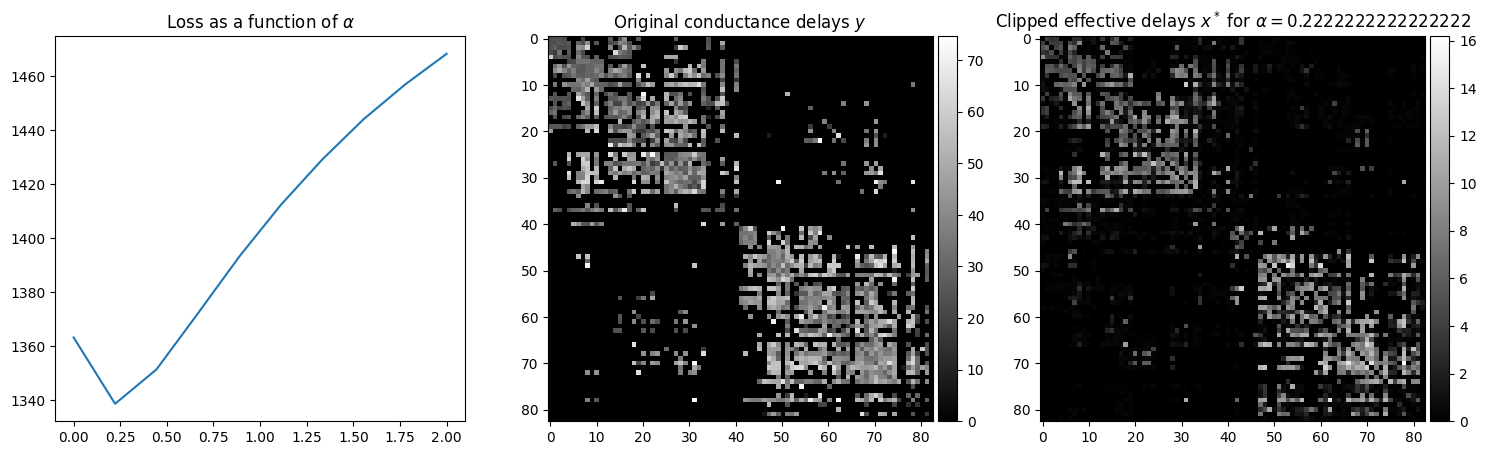

In [39]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(alphas, losses)
axes[0].set_title(r"Loss as a function of $\alpha$")

axes[1].imshow(y_ground_mat, cmap='gray')
axes[1].set_title(r"Original conductance delays $y$")
utils.add_cbar(fig, axes[1])

axes[2].imshow(all_sol[np.argmin(losses)], cmap='gray')
axes[2].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[np.argmin(losses)]}$")
utils.add_cbar(fig, axes[2])

In [40]:
utils.save("regressed_effective_delay.pkl",{'alphas': alphas,
                                            'losses': losses,
                                            'eff_delay': all_sol})